Explain what is up in this notebook here !

In [1]:
%%HTML
<video width="480" height="360" controls>
  <source src="../openai_lunarlander_video.mp4" type="video/mp4">
</video>

In [2]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from IPython.display import clear_output
import world
from dqn_agent import DQNAgent
from visualization_utils import *

%matplotlib inline

In [4]:
# from IPython import display as ipythondisplay
# from pyvirtualdisplay import Display
# display = Display(visible=0, size=(1400, 900))
# display.start()

In [5]:
class DoNothingAgent(object):
    
    name = 'do_nothing_agent'

    def __init__(self):
        pass

    def act(self, world_state):
        return 0

    
agent = DoNothingAgent()

_ = world.run_episode(agent)

In [6]:
%%HTML
<video width="480" height="360" controls>
  <source src="./video/do_nothing_agent/openaigym.video.5.1906.video000000.mp4" type="video/mp4">
</video>

In [7]:
class RandomAgent(object):
    
    name = 'random_agent'

    def __init__(self, num_actions=4):
        self.num_actions = num_actions

    def act(self, world_state):
        return random.randint(0, self.num_actions-1)

    
agent = RandomAgent()

_ = world.run_episode(agent)

In [8]:
class TrainedBehaviorAgent(object):
    
    name = 'trained_behavior_agent'

    def __init__(self):
        self.dqn_agent = DQNAgent()
        self.dqn_agent.qnetwork_local.load_state_dict(torch.load('../checkpoint0.pth', map_location='cpu'))
        self.dqn_agent.qnetwork_local.fc1.cpu()
        self.dqn_agent.qnetwork_local.fc2.cpu()
        self.dqn_agent.qnetwork_local.fc3.cpu()

    def act(self, world_state):
        return self.dqn_agent.act(world_state)
    
    def brain_state(self, world_state):
        
        brain_state = []
        
        network = self.dqn_agent.qnetwork_local
        x = world_state
        activations = x
        for i, subnet in enumerate(network.children()):
            try:
                subbrain_state = subnet.weight.detach().clone().cpu().numpy() * activations.detach().clone().cpu().numpy()
            except AttributeError:
                subbrain_state = subnet.weight.detach().clone().cpu().numpy() * activations
            brain_state.append(subbrain_state)
            activations = F.relu(subnet.cpu().float()(torch.tensor(activations).float()))
            

        return brain_state
        

    
agent = TrainedBehaviorAgent()

episode_history = world.run_episode(agent)

/home/josh/.local/share/virtualenvs/tsc-2019-jd39_7cJ/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [9]:
print(agent.dqn_agent.qnetwork_local)

QNetwork(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)


In [10]:
agent.dqn_agent.qnetwork_local.fc2.weight.is_cuda

False

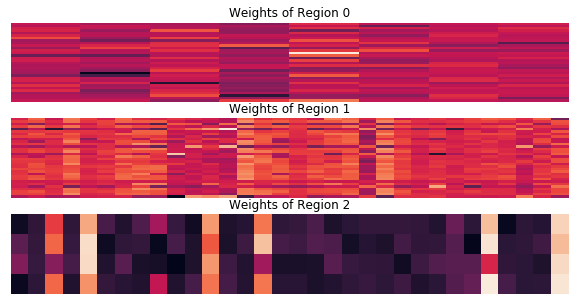

In [11]:
visualize_weights(agent.dqn_agent.qnetwork_local)

../visualization_utils.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  activations = F.relu(subnet.cpu().float()(torch.tensor(activations).float()))


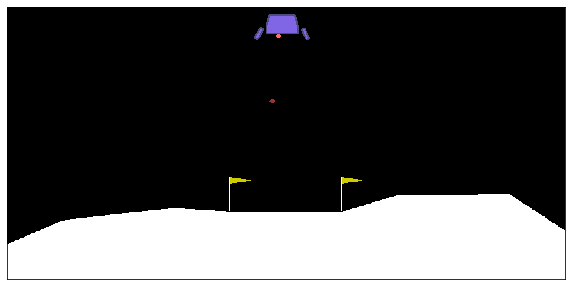

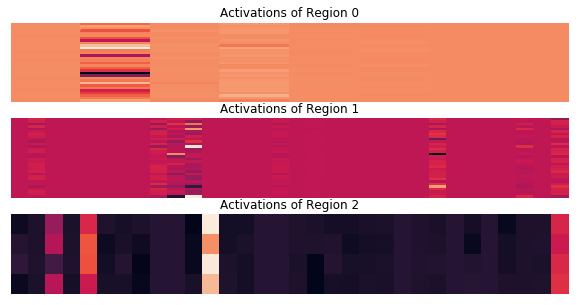

In [12]:
episode_index = 50
visualize_state(episode_history['world_image'][episode_index])
visualize_activations(agent.dqn_agent.qnetwork_local, episode_history['state'][episode_index])

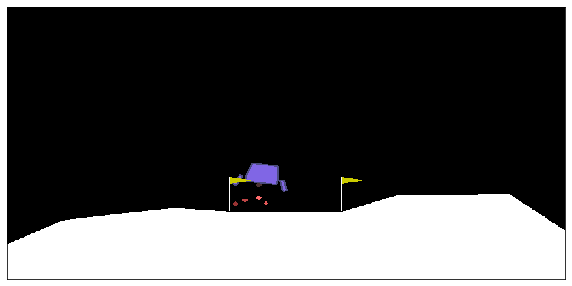

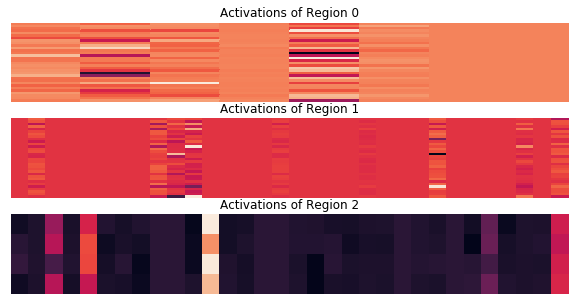

In [13]:
episode_index = -50
visualize_state(episode_history['world_image'][episode_index])
visualize_activations(agent.dqn_agent.qnetwork_local, episode_history['state'][episode_index])

In [14]:
from model import MLP

mental_states = [
    ["I believe I'm falling to fast", lambda state: state[3] < -0.2],
    ["I desire to land", lambda state: state[-2] != 1 and state[-1] != 1],
    ["I'm afraid to tip over", lambda state: np.abs(state[5]) > 0.2],
    ["I desire to go left", lambda state: state[0] > 0.2],
    ["I desire to go right", lambda state: state[0] < -0.2]
]
    

MLP(num_neurons=1408, num_mental_states=len(mental_states), fc_units=32)

class TrainedMentalAgent(TrainedBehaviorAgent):
    
    name = 'trained_mental_agent'

    def __init__(self):
        super(TrainedMentalAgent, self).__init__()
        self.mental_state_classifier = MLP(num_neurons=1408, num_mental_states=len(mental_states), fc_units=32)
        self.mental_state_classifier.load_state_dict(torch.load('../mental_classifer.pth'))
        self.mental_state_classifier.cpu()
        self.mental_states = mental_states
        
    def report_mental_state(self, state):
        brain_state = self.brain_state(state)
        brain_state = np.concatenate([array.flatten() for array in brain_state])
        mental_state = F.sigmoid(self.mental_state_classifier(torch.tensor(brain_state).float())).detach().clone().cpu().numpy()
        return [agent.mental_states[i][0] for i, m in enumerate(mental_state) if m > 0.5]


agent = TrainedMentalAgent()

episode_history = world.run_episode(agent)

/home/josh/.local/share/virtualenvs/tsc-2019-jd39_7cJ/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/josh/.local/share/virtualenvs/tsc-2019-jd39_7cJ/lib/python3.5/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


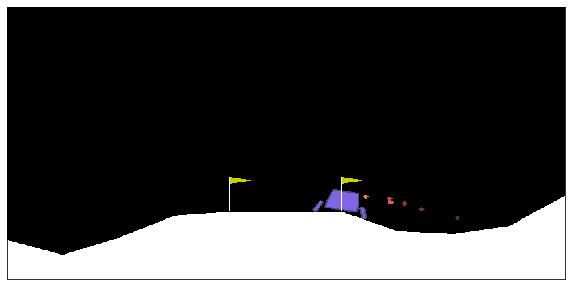

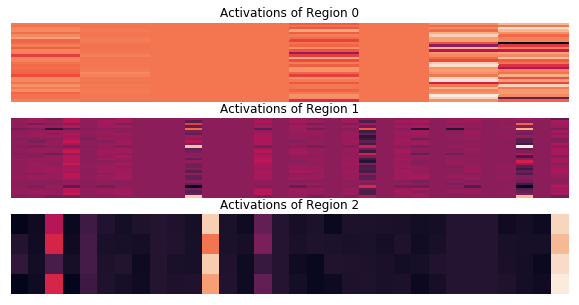

In [16]:
# for i in range(0, len(episode_history['state']), 25):
#     episode_index = i
#     visualize_state(episode_history['world_image'][episode_index])
#     visualize_activations(agent.dqn_agent.qnetwork_local, episode_history['state'][episode_index])
#     clear_output()
#     print('\n'.join(episode_history['reported_mental_state'][episode_index]))
#     plt.pause(2)

I believe I'm falling to fast
I desire to land


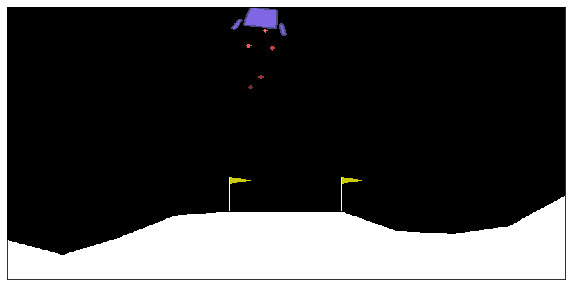

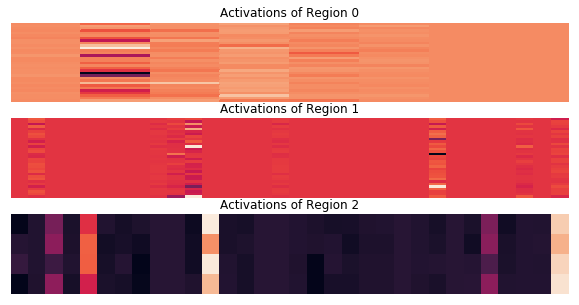

KeyboardInterrupt: 

In [17]:
animate_episode_history(episode_history, agent, steps_size=25, pause=3)

# Behaviorism

In [19]:
# Adapted from OpenAI's heuristic controller for lunar lander 

class BehaviorismAgent(object):
    
    name = 'behaviorism_agent'

    def __init__(self, num_actions=4):
        self.num_actions = num_actions

    def act(self, world_state):
        s = world_state
        angle_targ = s[0]*0.5 + s[2]*1.0
        if angle_targ >  0.4: 
            angle_targ =  0.4
        if angle_targ < -0.4: 
            angle_targ = -0.4
        hover_targ = 0.55*np.abs(s[0])
        angle_todo = (angle_targ - s[4])*0.5 - (s[5])*1.0
        hover_todo = (hover_targ - s[1])*0.5 - (s[3])*0.5
        if s[6] or s[7]:
            angle_todo = 0
            hover_todo = -(s[3])*0.5
        a = 0
        if hover_todo > np.abs(angle_todo) and hover_todo > 0.05:
            a = 2
        elif angle_todo < -0.05: 
            a = 3
        elif angle_todo > +0.05: 
            a = 1
        return a

    
agent = BehaviorismAgent()

episode_history = world.run_episode(agent)
episode_history['brain_state'] = None
episode_history['reported_mental_state'] = None

In [20]:
animate_episode_history(episode_history, agent, steps_size=25, pause=3)

KeyboardInterrupt: 

# Token-token Identity Theory

In [21]:
agent = TrainedMentalAgent()

episode_history = world.run_episode(agent)

/home/josh/.local/share/virtualenvs/tsc-2019-jd39_7cJ/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


I desire to land


/home/josh/.local/share/virtualenvs/tsc-2019-jd39_7cJ/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


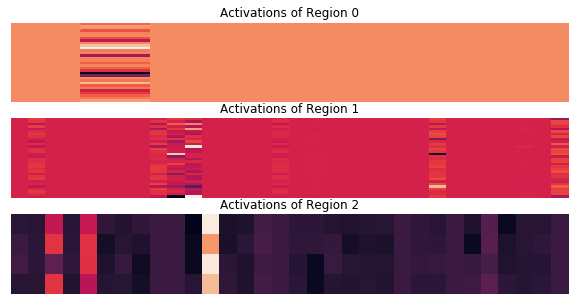

In [22]:
state = np.asarray([0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float32)
visualize_activations(agent.dqn_agent.qnetwork_local, state)
print('\n'.join(agent.report_mental_state(state)))

I desire to land


/home/josh/.local/share/virtualenvs/tsc-2019-jd39_7cJ/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


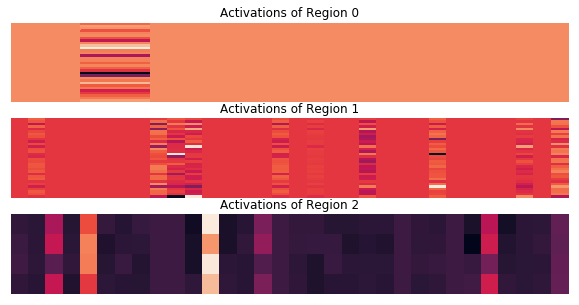

In [23]:
state = np.asarray([0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float32)
visualize_activations(agent.dqn_agent.qnetwork_local, state)
print('\n'.join(agent.report_mental_state(state)))

I'm afraid to tip over


/home/josh/.local/share/virtualenvs/tsc-2019-jd39_7cJ/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


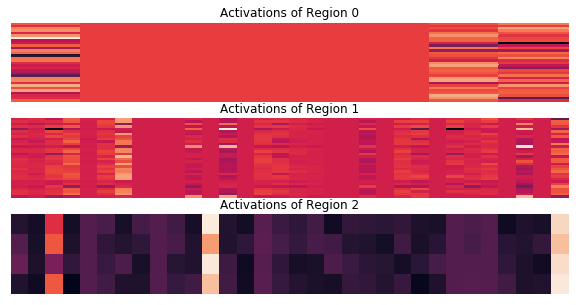

In [24]:
state = np.asarray([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0], dtype=np.float32)
visualize_activations(agent.dqn_agent.qnetwork_local, state)
print('\n'.join(agent.report_mental_state(state)))

I'm afraid to tip over


/home/josh/.local/share/virtualenvs/tsc-2019-jd39_7cJ/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


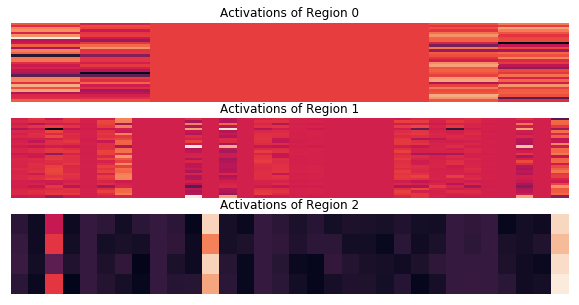

In [25]:
state = np.asarray([1.0, 0.5, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0], dtype=np.float32)
visualize_activations(agent.dqn_agent.qnetwork_local, state)
print('\n'.join(agent.report_mental_state(state)))

# Functionalism

In [27]:
class FunctionalismAgent(object):
    
    name = 'functionalism_agent'

    def __init__(self, num_actions=4):
        self.num_actions = num_actions

    def act(self, world_state):
        
        if self.falling_too_fast_belief_mental_state(world_state):
            a = 2
        elif self.fear_of_tipping_to_the_left(world_state):
            a = 3
        elif self.fear_of_tipping_to_the_right(world_state):
            a = 1
        elif self.desire_go_left_mental_state(world_state):
            a = 1
        elif self.desire_go_right_mental_state(world_state):
            a = 3
        elif self.desire_to_land_mental_state(world_state):
            a = 0
        else:
            a = 0
        return a
    
    def fear_of_tipping_to_the_left(self, world_state):
        s = world_state
        angle_todo = (s[0]*0.5 + s[2]*1.0 - s[4])*0.5 - (s[5])*1.0
        hover_todo = (0.55*np.abs(s[0]) - s[1])*0.5 - (s[3])*0.5
        return (not (hover_todo > np.abs(angle_todo) and hover_todo > 0.05) 
                and angle_todo < -0.05)
    
    def fear_of_tipping_to_the_right(self, world_state):
        s = world_state
        angle_todo = (s[0]*0.5 + s[2]*1.0 - s[4])*0.5 - (s[5])*1.0
        hover_todo = (0.55*np.abs(s[0]) - s[1])*0.5 - (s[3])*0.5
        return (not (hover_todo > np.abs(angle_todo) and hover_todo > 0.05) 
                and angle_todo > +0.05)
    
    def falling_too_fast_belief_mental_state(self, world_state):
        return world_state[3] < -0.2
    
    def desire_to_land_mental_state(self, world_state):
        return (world_state[-2] != 1 and world_state[-1] != 1)
    
    def desire_go_left_mental_state(self, world_state):
        return world_state[0] > 0.1
    
    def desire_go_right_mental_state(self, world_state):
        return world_state[0] < -0.1
        

    
agent = FunctionalismAgent()

episode_history = world.run_episode(agent)